# GRIP - THE SPARKS FOUNDATION

## TASK 7 - Stock Market Prediction using Numerical and Textual Analysis

## Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines


In [2]:
import nltk

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Importing Required Libraries

In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Reading the data and doing the EDA

In [6]:
stock_price = pd.read_csv('TASK 7\dataset.csv')
news_headline = pd.read_csv('TASK 7\india-news-headlines.csv')

In [10]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [11]:
news_headline.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [12]:
stock_price.isna().any(), news_headline.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [13]:
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price.set_index('Date', inplace= True)
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...
2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0
2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0
2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0


In [14]:
news_headline = news_headline.drop_duplicates()
news_headline['publish_date'] = news_headline['publish_date'].astype(str)
news_headline['publish_date'] = news_headline['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
news_headline['publish_date'] = pd.to_datetime(news_headline['publish_date']).dt.normalize()
news_headline = news_headline.filter(['publish_date', 'headline_text'])
news_headline = news_headline.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
news_headline.set_index('publish_date', inplace= True)
news_headline = news_headline.sort_index(ascending=True, axis=0)
news_headline

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [15]:
stock_data = pd.concat([stock_price, news_headline], axis=1)
stock_data.dropna(axis=0, inplace=True)
stock_data

,Open,High,Low,Close,Adj Close,Volume,headline_text
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...
...,...,...,...,...,...,...,...
2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...
2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0,"No threat from Covid claims to balance sheets,..."
2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...
2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...


In [16]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...,,,,
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...,,,,
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...,,,,
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...,,,,
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...,,,,


### Doing the sentimental analysis and calculating compound,positive,neutral,negative

In [17]:
sid = SentimentIntensityAnalyzer()
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.178,0.748,0.074
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.146,0.782,0.072
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9997,0.110,0.833,0.057
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...,-0.9999,0.157,0.769,0.074
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997,0.131,0.788,0.081


In [19]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,headline_text,compound,negative,neutral,positive
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000,0.178,0.748,0.074
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999,0.146,0.782,0.072
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9997,0.110,0.833,0.057
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...,-0.9999,0.157,0.769,0.074
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997,0.131,0.788,0.081
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...,-0.9999,0.147,0.772,0.081
2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0,"No threat from Covid claims to balance sheets,...",-0.9993,0.112,0.808,0.081
2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0,1;147 RT-PCR tests in a day; only 3 found +ve ...,-0.9998,0.123,0.802,0.074
2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...,-0.9994,0.105,0.820,0.075


In [20]:
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2019-12-17,41352.171875,-1.0000,0.178,0.748,0.074,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.146,0.782,0.072,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,0.110,0.833,0.057,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.157,0.769,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,0.131,0.788,0.081,41548.261719,41701.621094,41474.609375,6200.0


In [21]:
stock_data.to_csv('stock_data.csv')

In [22]:
stock_data = pd.read_csv('stock_data.csv', index_col = False)
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2019-12-17,41352.171875,-1.0000,0.178,0.748,0.074,41052.359375,41401.648438,41005.179688,19000.0
2019-12-18,41558.570313,-0.9999,0.146,0.782,0.072,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,0.110,0.833,0.057,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,0.157,0.769,0.074,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,0.131,0.788,0.081,41548.261719,41701.621094,41474.609375,6200.0


### Plotting the close price graph

Text(0, 0.5, 'Close Price (Rs.)')

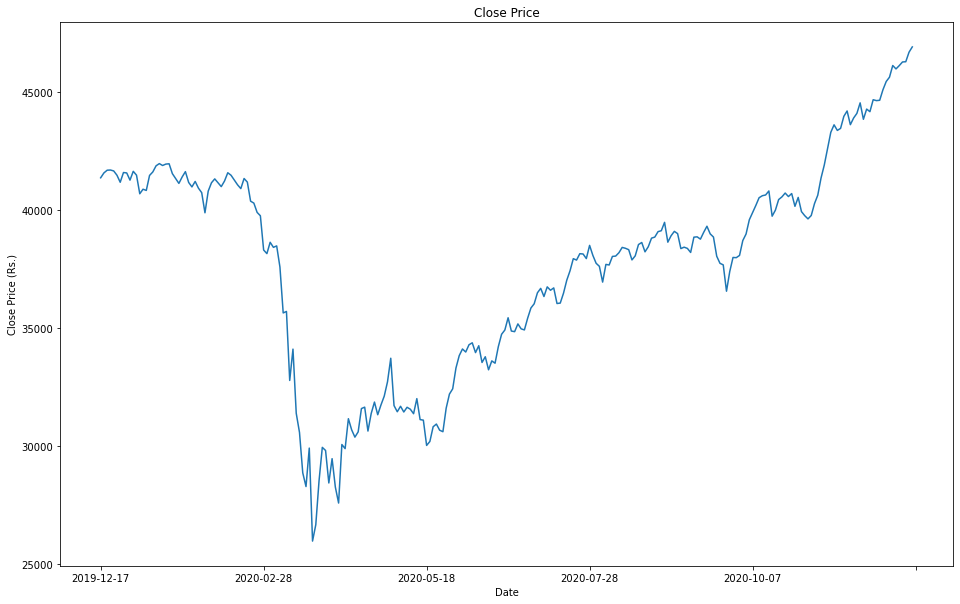

In [23]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (Rs.)')

### Distributing the data for training and testing

In [24]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))
train_end = int(data_to_use*0.85)
total_data = len(stock_data)
start = total_data - data_to_use
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 211
Number of records in Test Data: 39


In [25]:
steps_to_predict = 1
close_price = stock_data.iloc[start:total_data,0] 
compound = stock_data.iloc[start:total_data,1]
negative = stock_data.iloc[start:total_data,2] 
neutral = stock_data.iloc[start:total_data,3] 
positive = stock_data.iloc[start:total_data,4]
open_price = stock_data.iloc[start:total_data,5] 
high = stock_data.iloc[start:total_data,6] 
low = stock_data.iloc[start:total_data,7] 
volume = stock_data.iloc[start:total_data,8] 
print("Close Price:")
close_price

Close Price:


Date
2019-12-18    41558.570313
2019-12-19    41673.921875
2019-12-20    41681.539063
2019-12-23    41642.660156
2019-12-24    41461.261719
                  ...     
2020-12-11    46099.011719
2020-12-14    46253.460938
2020-12-15    46263.171875
2020-12-16    46666.460938
2020-12-17    46890.339844
Name: Close, Length: 249, dtype: float64

In [26]:
close_price_shifted = close_price.shift(-1) 
compound_shifted = compound.shift(-1) 
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2019-12-18,41558.570313,41673.921875,-0.9999,-0.9997,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,41681.539063,-0.9997,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,41642.660156,-0.9999,-0.9997,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,41461.261719,-0.9997,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,41163.761719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
2019-12-26,41163.761719,41575.140625,-0.9999,-0.9999,5600.0,41543.800781,41543.800781,41132.890625
2019-12-27,41575.140625,41558.000000,-0.9999,-0.9999,6100.0,41297.078125,41611.269531,41264.921875
2019-12-30,41558.000000,41253.738281,-0.9999,-0.9999,5700.0,41686.269531,41714.730469,41453.378906
2019-12-31,41253.738281,41626.640625,-0.9999,-0.9997,5600.0,41607.488281,41607.488281,41184.730469


### Setting the target variable

In [27]:
y = data['close_price_shifted']
y

Date
2019-12-18    41673.921875
2019-12-19    41681.539063
2019-12-20    41642.660156
2019-12-23    41461.261719
2019-12-24    41163.761719
                  ...     
2020-12-10    46099.011719
2020-12-11    46253.460938
2020-12-14    46263.171875
2020-12-15    46666.460938
2020-12-16    46890.339844
Name: close_price_shifted, Length: 248, dtype: float64

In [28]:
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2019-12-18,41558.570313,-0.9999,-0.9997,24300.0,41442.750000,41614.769531,41358.468750
2019-12-19,41673.921875,-0.9997,-0.9999,33300.0,41571.820313,41719.289063,41456.398438
2019-12-20,41681.539063,-0.9999,-0.9997,33600.0,41746.199219,41809.960938,41636.109375
2019-12-23,41642.660156,-0.9997,-0.9999,6200.0,41548.261719,41701.621094,41474.609375
2019-12-24,41461.261719,-0.9999,-0.9999,4400.0,41684.511719,41702.980469,41423.070313
...,...,...,...,...,...,...,...
2020-12-10,45959.878906,-0.9996,-0.9999,12700.0,45999.421875,46043.968750,45685.871094
2020-12-11,46099.011719,-0.9999,-0.9993,26300.0,46060.320313,46309.628906,45706.218750
2020-12-14,46253.460938,-0.9993,-0.9998,18400.0,46284.699219,46373.339844,45951.531250


In [29]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)
x[0:5], y

(array([[ 0.50613139, -0.99989987, -0.99969961, -0.78357803,  0.48882267,
          0.470931  ,  0.51416868],
        [ 0.51728443, -0.99969961, -0.99989987, -0.68569875,  0.50168244,
          0.48179463,  0.52360164],
        [ 0.51802091, -0.99989987, -0.99969961, -0.68243611,  0.51905648,
          0.49121895,  0.54091208],
        [ 0.51426181, -0.99969961, -0.99989987, -0.98042414,  0.49933521,
          0.47995824,  0.52535578],
        [ 0.49672287, -0.99989987, -0.99989987, -1.        ,  0.51291032,
          0.48009953,  0.52039135]]),
 array([[ 0.50103849],
        [ 0.50176709],
        [ 0.49804824],
        [ 0.48069709],
        [ 0.45224058],
        [ 0.49158985],
        [ 0.48995031],
        [ 0.46084703],
        [ 0.49651594],
        [ 0.4810173 ],
        [ 0.40564529],
        [ 0.42409083],
        [ 0.4191427 ],
        [ 0.47984482],
        [ 0.4939408 ],
        [ 0.51880774],
        [ 0.52769741],
        [ 0.52005496],
        [ 0.52577764],
        [ 0

### Splitting the data into train and test data

In [30]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (211, 7) and y: (211, 1)
Number of rows and columns in the Test set X: (36, 7) and y: (36, 1)


In [31]:
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (211, 7, 1)
Shape of Test set X: (36, 7, 1)


### Creating the LSTM model for prediciton of stock prices

In [32]:
np.random.seed(2016)
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [33]:
model.compile(loss='mse' , optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
21/21 [==============================] - 7s 89ms/step - loss: 0.1450 - val_loss: 0.0313
Epoch 2/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0830 - val_loss: 0.0066
Epoch 3/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0168 - val_loss: 0.0021
Epoch 4/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0088 - val_loss: 0.0030
Epoch 5/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 6/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0026
Epoch 7/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0093 - val_loss: 0.0118
Epoch 8/10
21/21 [==============================] - 0s 17ms/step - loss: 0.0095 - val_loss: 0.0024
Epoch 9/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 10/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0091 - val_loss: 0.0029


### Saving model 

In [34]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [35]:
X_test[0:5]

array([[[ 0.36950531],
        [-0.99929909],
        [-0.99989987],
        [-0.93800979],
        [ 0.40981419],
        [ 0.37838693],
        [ 0.3783348 ]],

       [[ 0.40591793],
        [-0.99989987],
        [-0.99979974],
        [-0.89668298],
        [ 0.36491084],
        [ 0.36084239],
        [ 0.3812343 ]],

       [[ 0.34794024],
        [-0.99979974],
        [-0.99989987],
        [-0.7281131 ],
        [ 0.41126783],
        [ 0.37214573],
        [ 0.36160456]],

       [[ 0.33125109],
        [-0.99989987],
        [-0.99989987],
        [-0.83578032],
        [ 0.29896257],
        [ 0.30421931],
        [ 0.33748974]],

       [[ 0.31812276],
        [-0.99989987],
        [-0.99959948],
        [-0.91734638],
        [ 0.32313857],
        [ 0.30187257],
        [ 0.31028993]]])

### Prediciting the stock prices by putting data in trained model

In [36]:
predictions = model.predict(X_test) 
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))
print('Predictions:')
predictions[0:10]

Predictions:


array([[39958.34 ],
       [40279.34 ],
       [40344.4  ],
       [39641.6  ],
       [39342.31 ],
       [39578.375],
       [40238.367],
       [40578.73 ],
       [42079.39 ],
       [41943.38 ]], dtype=float32)

In [37]:
train_loss = model.evaluate(X_train, y_train, batch_size = 1)
test_loss = model.evaluate(X_test, y_test, batch_size = 1)
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

36/36 [==============================] - 0s 3ms/step - loss: 0.0620
Train Loss = 0.006
Test Loss = 0.062


### Checking the root mean square error

In [38]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 44500.4172


In [39]:
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 44500.4172


In [40]:
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

### Plotting the comparsion graph of Close price and Predicted price

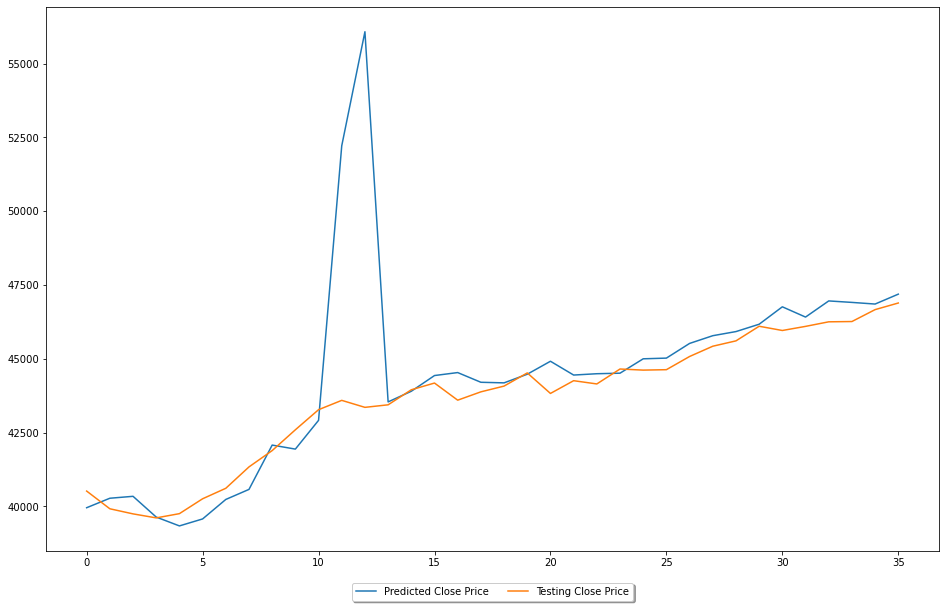

In [41]:
plt.figure(figsize=(16,10))
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()